In [70]:
import os
import pickle
from tqdm import tqdm
import sentencepiece as spm

In [71]:
source_folder = '/scratche/home/apoorv/EmbedKGQA/data/fbwq_full'
! ls {source_folder}

dataset.yaml			    relations_all.dict
entities.dict			    relations.dict
entity_ids.del			    test.del
entity_ids.del-True-t-False.pckl    test.del-t.pckl
entity_ids.del-True-t-True.pckl     test.txt
index-test_po_to_s.pckl		    test_without_unseen.del
index-test_sp_to_o.pckl		    train.del
index-train_po_to_s.pckl	    train.del-t.pckl
index-train_sp_to_o.pckl	    train_sample.del
index-valid_po_to_s.pckl	    train.txt
index-valid_sp_to_o.pckl	    valid.del
pruning_train.txt		    valid.del-t.pckl
relation_ids.del		    valid.txt
relation_ids.del-True-t-False.pckl  valid_without_unseen.del
relation_ids.del-True-t-True.pckl


In [72]:
fname = 'entities.dict'
entities = []
for line in open(os.path.join(source_folder, fname)):
    line = line.strip().split('\t')
    entities.append(line[0])
    
fname = 'relations.dict'
relations = []
for line in open(os.path.join(source_folder, fname)):
    line = line.strip().split('\t')
    relations.append(line[0])

In [73]:
def readTriples(fname):
    f = open(fname)
    triples = []
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        triples.append(line.split('\t'))
    f.close()
    return triples

In [74]:
# load half data
data = {}
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(source_folder, split + '.txt')
    data[split] = readTriples(fname)

In [75]:
data['train'][5000]

['m.02sy14', 'people.person.nationality', 'm.09c7w0']

In [76]:
from unidecode import unidecode
# lowering everything

def normalizeRelation(rel):
#     rel = rel.replace('_', ' ')
    rel = unidecode(rel)
    rel = rel.split('.')[-1]
    rel = rel.replace('_', ' ')
    rel = rel.lower()
    return rel

def normalizeEntity(ent):
    ent = unidecode(ent)
    ent = ent.lower()
    return ent

def getBestName(names, max_words = 5):
    best_name = names[0]
    for name in names:
        if name.endswith('@en'):
            best_name = name
    name = best_name.replace('"', '')
    name = name.split('@')[0]
    name = normalizeEntity(name)
#     name = name[:max_len]
    name = ' '.join(name.split()[:max_words])
    return name

def getBestDescription(descriptions, max_description_words=8):
    best_desc = descriptions[0]
    for desc in descriptions:
        if desc.endswith('@en'):
            best_desc = desc
    desc = best_desc
    desc = (''.join(desc.split('@')[:-1])).replace('"', '')
    desc = ' '.join(desc.split()[:max_description_words])
    # unidecode stuff
    desc = normalizeEntity(desc)
    return desc

def addDescriptionToName(name, desc):
    desc = desc.replace(name, 'it')
    desc = desc.replace('it is a ', '')
    desc = desc.replace('it was a ', '')
    desc = desc.replace('it was an ', '')
    desc = desc.replace('it is an ', '')
    desc = desc.replace('it is the ', '')
    desc = desc.replace('it was the ', '')
    desc = desc.replace('.', '')
    name = name + ' (' + desc + ')'
    return name

def truncateWords(name, num_words):
    name = name.split()[:num_words]
    name = ' '.join(name)
    return name

In [89]:
import pickle
from tqdm import tqdm
aliases_dict = {}
count = 0
fname = '/scratche/home/apoorv/freebase/ent_identifiers_fbwq_full.pickle'
x = pickle.load(open(fname, 'rb'))
descriptions = {}

In [90]:
max_name_words = 12
for ent in tqdm(entities):
    if ent not in x:
        aliases_dict[ent] = getBestName([ent]) # to unidecode basically
        count += 1
        continue
    reldict = x[ent]
    if 'type.object.name' in reldict.keys():
        names = reldict['type.object.name']
        name = getBestName(names, 7)
        aliases_dict[ent] = name
    elif 'common.topic.description' in reldict.keys():
        descs = reldict['common.topic.description']
        name = getBestName(descs)
        aliases_dict[ent] = name
    elif 'common.topic.alias' in reldict.keys():
        als = reldict['common.topic.alias']
        name = getBestName(als)
        aliases_dict[ent] = name
    else:
        aliases_dict[ent] = getBestName([ent])
        count += 1
    if 'common.topic.description' in reldict.keys():
        descriptions[ent] = reldict['common.topic.description']

100%|██████████| 1886683/1886683 [00:10<00:00, 182391.86it/s]


In [91]:
(''.join(descriptions['m.0bdtd0y'][0].split('@')[:-1])).replace('"', '')

'The Door is a 2009 drama-mystery film directed by Anno Saul.'

In [92]:
i = 0
count = 0
for k, v in aliases_dict.items():
    if v.startswith('g.') or v.startswith('m.'):
        count += 1
count

466751

In [93]:
for k, v in tqdm(aliases_dict.items()):
    if v == 'andante':
        print(k)

 30%|██▉       | 557526/1886681 [00:00<00:00, 1689028.14it/s]

m.023bt5d
m.0246ldz
m.0246mrw
m.0246qhf
m.0246vd7


 82%|████████▏ | 1556138/1886681 [00:00<00:00, 2252154.82it/s]

m.0_sbf9
m.0dp4kzg
m.0ffmx61
m.0fvgt68
m.0g91jfv
m.0gdd814
m.0gfrrbr
m.0pd1m03


100%|██████████| 1886681/1886681 [00:00<00:00, 2145602.25it/s]

m.0v7pt9
m.0vfxz6
m.0w3xy1
m.0xgp1rf


In [94]:
relation_map = {}
for rel in relations:
    rel_processed = normalizeRelation(rel)
    relation_map[rel] = rel_processed

In [95]:
entity_map = {}
for ent in entities:
    entity_map[ent] = aliases_dict[ent]

In [96]:
len(relation_map), len(set(relation_map.values()))

(1144, 920)

In [97]:
len(entity_map), len(set(entity_map.values()))

(1886681, 1708331)

In [98]:
# don't care about uniqueness, since application is KGQA
# and not KGC
def getUniqueMap(init_map):
    out_map = {}
    aliases_done_reverse_dict = {}
    max_description_words = 8
    
    for key, value in init_map.items():
        if value not in out_map:
            aliases_done_reverse_dict[value] = key
        else:
            if key in descriptions:
                desc = getBestDescription(descriptions[key], max_description_words)
                # remove name from description, since it will be repeated?
                value = addDescriptionToName(value, desc)
        out_map[key] = value
        
    return out_map

def mapTriple(triple, ent_map, rel_map):
    t = triple
    if t[0] not in ent_map or t[2] not in ent_map:
        print(t)
        return t
    
    new_triple = [ent_map[t[0]], rel_map[t[1]], ent_map[t[2]]]
    return new_triple

In [99]:
uniq_ent_map = getUniqueMap(entity_map)

In [100]:
entity_map['"Nastavnik"@h']

'nastavnik'

In [101]:
for id in range(500):
    print(mapTriple(data['train'][id], uniq_ent_map, relation_map))

['g.113qbnjlk', 'country', 'socialist federal republic of yugoslavia']
['g.119pgc86w', 'country', 'east germany']
['g.119pgkfwp', 'country', 'germany']
['g.11_p4_gjd', 'position s', 'midfielder']
['g.11_p4_gjd', 'nationality', 'morocco']
['g.11_pl46ml', 'country', 'turkey']
['g.11b60s4p1_', 'country', 'germany']
['g.11b62_430s', 'country', 'sweden']
['g.11b66j1qpc', 'containedby', 'massachusetts']
['g.11b66j1qpc', 'time zones', 'eastern time zone']
['g.11b6b4217d', 'nationality', 'poland']
['g.11b6b4217d', 'position s', 'midfielder']
['g.11b6bbz4lt', 'country', 'japan']
['g.11b6fx5vr2', 'containedby', 'italy']
['g.11b6fx5vr2', 'containedby', 'calabria']
['g.11b6g27zwp', 'containedby', 'calabria']
['g.11b6g27zwp', 'containedby', 'italy']
['g.11b6g6_pv1', 'nationality', 'portugal']
['g.11b6g6_pv1', 'position s', 'midfielder']
['g.11b6g6qf3x', 'containedby', 'calabria']
['g.11b6g6qf3x', 'containedby', 'italy']
['g.11b6g7g4sw', 'containedby', 'calabria']
['g.11b6g7g4sw', 'containedby', 'it

In [102]:
import pickle
fname = '../freebase/webqsp_aliases_from_questions.pickle'
webqsp_aliases = pickle.load(open(fname, 'rb'))

In [103]:
count = 0
for key, value in webqsp_aliases.items():
    if key in uniq_ent_map:
        val_from_map = uniq_ent_map[key]
        value = normalizeEntity(value)
        # TODO: randomly chose 12 words
        value = truncateWords(value, 12)
        if value != val_from_map:
            count += 1
            uniq_ent_map[key] = value
#             print(key, '*', value, '*', val_from_map)
count      

6069

In [104]:
len(data['train'])

5780246

In [105]:
# save maps
import pickle
fname = 'data/fbwq_full/ent_map_fbwq_full.pickle'
pickle.dump(uniq_ent_map, open(fname, 'wb'))
fname = 'data/fbwq_full/rel_map_fbwq_full.pickle'
pickle.dump(relation_map, open(fname, 'wb'))

In [106]:
out_folder = '/scratche/home/apoorv/transformer-kgc/data/fbwq_full'
splits = ['train', 'test', 'valid']

count = 0
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        
        t = mapTriple(t, uniq_ent_map, relation_map)
        # only save those that DO NOT start with m. or g.
        # we can do that since aim is KGQA not KGC
        head, relation, tail = t
        if head.startswith('m.') or head.startswith('g.'):
            count += 1
            continue
        if tail.startswith('m.') or tail.startswith('g.'):
            count += 1
            continue
        input = 'predict tail: {0} | {1} |'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1} |'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

['m.0gdtw1r', 'type.object.name', ' Never Can Say Goodbye"@e']
['m.02x8n1n', 'type.object.name', ' Bester Nebendarsteller"@d']
['m.010xh2s4', 'type.object.name', ' Stay"@e']
['m.09sdmz', 'type.object.name', ' Bester Nebendarsteller"@d']
['g.11b821q1dm', 'type.object.name', ' Acte IV, scène 2. Un appartement dans le château"@f']
['g.11b821q1dm', 'type.object.name', ' Acte IV, scène 2. Un appartement dans le château"@f']
['g.11b821q1dm', 'type.object.name', ' Acte IV, scène 2. Un appartement dans le château"@f']
['m.0_hs1gl', 'type.object.name', ' II. Kyrie"@l']
['m.0zl21_0', 'type.object.name', ' KV deest: Canon"@l']
['m.018cgg4', 'type.object.name', ' No Limit"@e']
['m.0zjbtss', 'type.object.name', ' no. 3 in E-flat major, K. 509: German Dance & Trio"@e']
['m.0rk7n_b', 'type.object.name', ' Into the Mystic"@e']
['m.0gqy2', 'type.object.name', ' Bester Nebendarsteller"@d']
['m.0nljcpm', 'type.object.name', ' Into the Mystic"@e']
['m.0_hrz7g', 'type.object.name', ' Acte IV, scène 2. Un a

In [107]:
count

1019066

In [108]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = set(uniq_ent_map.values())
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [99]:
# webqsp qa 
# def readQALines(fname):
#     f = open(fname)
#     questions = []
#     for line in f:
#         line = line.strip().split('\t')
#         q = line[0]
#         lhs = q.split('[')[0]
#         rhs = q.split(']')[1]
#         only_question = lhs + 'NE' + rhs
#         only_question = normalizeEntity(only_question)
# #         q = q.replace('[', '')
# #         q = q.replace(']', '')
# #         q = normalizeEntity(q)
#         questions.append(only_question)
#     return questions
        
# def writeLines(lines, fname):
#     f = open(fname, 'w')
#     for line in lines:
#         f.write(line + '\n')


'what character did natalie portman play in star wars NE'

In [81]:
# fname = 'data/MetaQA/full_qa.txt'
# questions = readQALines(fname)
# questions = list(set(questions))

In [82]:
# fname = 'data/MetaQA/only_questions_text.txt'
# writeLines(questions, fname)

In [138]:
vocab_size = 30000
sp = spm.SentencePieceTrainer.train(input='data/fbwq_half/train.txt', 
                                    model_prefix='fbwq_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['predict',
#                                                     'head',
#                                                     'tail',
#                                                     '|'],
#                                     normalization_rule_name='identity',
                              )

In [139]:
# sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')
sp = spm.SentencePieceProcessor(model_file='fbwq_with_pad.model')

In [38]:
# sp['Obama']

0

In [151]:
sp.decode(sp.encode('how old'))

'how old'

In [192]:
sp.encode('<pad>')

[5, 0, 12497, 0]

In [195]:
sp['</s>']

2

In [193]:
sp.id_to_piece(3)

'<pad>'

In [176]:
lengths = []
count = 0
for e in tqdm(ents_uniq):
    encoded = sp.encode(e)
    l = len(encoded)
    if l > 500:
        print(e,l)
        l = 20
        count += 1
    lengths.append(l)
count

100%|██████████| 1712213/1712213 [00:18<00:00, 91029.72it/s] 


0

Text(0.5, 0, 'Tokenized lengths')

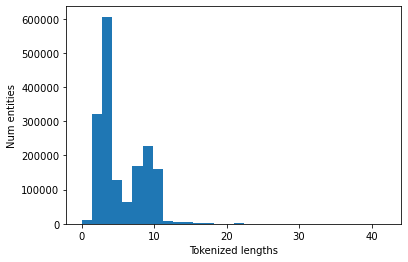

In [177]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [190]:
lengths = []
count = 0
for e in tqdm(relations):
    encoded = sp.encode(relation_map[e])
    l = len(encoded)
    if l > 10:
        print(relation_map[e])
        count +=1
    lengths.append(l)
count

100%|██████████| 1068/1068 [00:00<00:00, 41292.34it/s]

astronomical objects discovered
astronomical objects discovered reverse
sewage treatment plant
sewage treatment plant reverse
infidelity perpetrator reverse
substance abuse reverse
lifetime batting statistics reverse
sponsored by reverse
substance abuse problems reverse
appears in these fictional universes reverse
jurisdiction of office reverse
body this is a component of reverse
politicians in this party reverse
websites owned reverse
tropical cyclone season reverse
olympics hosted reverse
types of places of worship reverse
athletic performances reverse
mode of transportation reverse
appeared in tv episodes reverse
episodes appeared in reverse


21

Text(0.5, 0, 'Tokenized lengths')

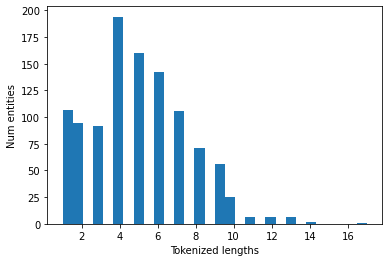

In [186]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [191]:
sp.encode('plays for')

[167, 10, 96]

In [104]:
len(uniq_ent_map)

1880592

In [143]:
def replaceEntities(line, aliases_dict):
    line = line.strip().split('\t')
    q = line[0]
    # sometimes no answer
    if len(line) > 1:
        answers= line[1].split('|')
    else:
        answers = []    
    lhs = q.split('[')[0]
    rhs = q.split(']')[1]
    head_id = q.split('[')[1].split(']')[0]
    if head_id in aliases_dict:
        head_text = aliases_dict[head_id]
    else:
        head_text = head_id
        print(head_text + ' not found')
    answers_text = []
    for a in answers:
        if a in aliases_dict:
            answers_text.append(aliases_dict[a])
        else:
            answers_text.append(a)
    answers_string = '|'.join(answers_text)
    
    out = '{lhs}[{head}]{rhs}\t{ans}'.format(
        lhs=lhs,
        rhs=rhs,
        head = head_text,
        ans = answers_string
    )
    return out
        
def readLines(fname):
    f = open(fname)
    lines = []
    for line in f:
        lines.append(line.rstrip())
    f.close()
    return lines

def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [137]:
# need to make qa data as well, since entity aliases need to be used
# and not just entity ids as answers
fname = '/scratche/home/apoorv/EmbedKGQA/data/QA_data/WebQuestionsSP/qa_test_webqsp_fixed.txt'
questions = readLines(fname)


In [138]:
questions[1]

'what did james k polk do before he was president [m.042f1]\tm.02_bcst|m.04x_n9q|m.0cgqx'

In [144]:
lines_with_entities = [replaceEntities(q, uniq_ent_map) for q in questions]

m.02vkmj9 not found


In [145]:
len(lines_with_entities)

1639

In [146]:
lines_with_entities[:10]

['what does jamaican people speak [Jamaica 1]\tJamaican English|Jamaican Creole English Langua|Jamaican English',
 'what did james k polk do before he was president [James K. Polk]\tUnited States Representative|Governor of Tennessee|Speaker of the United States H',
 'who plays ken barlow in coronation street [Coronation Street]\tWilliam Roache',
 'where is jamarcus russell from [JaMarcus Russell]\tMobile 0',
 'where was george washington carver from [George Washington Carver]\tDiamond 8',
 'what else did ben franklin invent [Benjamin Franklin]\tLightning rod|Bifocals|Glass harmonica|Franklin stove',
 'who was richard nixon married to [Richard Nixon]\tPat Nixon',
 'who is governor of ohio 2011 [Ohio 2]\tJohn Kasich|Return J. Meigs, Jr.|Ted Strickland',
 'who was vice president after kennedy died [John F. Kennedy 0]\tLyndon B. Johnson 1',
 'where is the fukushima daiichi nuclear plant located [Fukushima Daiichi Nuclear Powe]\tJapan 1|Okuma']

In [148]:
fname = 'data/fbwq_half/qa_valid_1hop.txt'
writeLines(lines_with_entities, fname)